# Lab 3.2: Human-in-the-Loop (HITL) Basics

In this lab, we will implementation a **Real-World Customer Support Scenario**.

### The Scenario
We have an AI Agent that drafts responses to customer queries.
However, before sending the email, a **Human Manager** (you) must review and approve the draft.
If the draft is not good, the human can **edit** it before it is sent.

### Key Concepts
1. **Interrupts**: Pausing the graph before the email sending node.
2. **State Inspection**: Reviewing the AI's draft.
3. **State Update**: Manually correcting the draft.
4. **Resuming**: Allowing the "Send Email" node to execute with the corrected text.

In [1]:
# 1. Install Dependencies
%pip install -qU langchain-groq langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 2. Setup API Keys
import getpass
import os

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API Key: ")

## 3. Define the Support Bot Graph

- **State**: Takes a `customer_query` and stores a `draft_response`.
- **Node 1 (`draft_reply`)**: Uses an LLM to generate a draft.
- **Node 2 (`send_email`)**: Simulates sending the final email.
- **Interrupt**: We will `interrupt_before` the `send_email` node.

In [3]:
from typing import TypedDict, Optional
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq

# --- 1. Define State ---
class SupportState(TypedDict):
    customer_query: str
    draft_response: Optional[str]
    final_status: Optional[str]

# --- 2. Define Nodes ---
llm = ChatGroq(model_name="llama-3.3-70b-versatile")

def draft_reply(state: SupportState):
    print("--- (AI) Drafting Reply ---")
    query = state['customer_query']
    # Ask LLM to be polite and concise
    response = llm.invoke(f"Write a polite, concise support email response to this customer complaint: {query}")
    return {"draft_response": response.content}

def send_email(state: SupportState):
    print("--- (System) Sending Email ---")
    draft = state['draft_response']
    # Simulate sending
    return {"final_status": f"SENT: {draft}"}

# --- 3. Build Graph ---
builder = StateGraph(SupportState)
builder.add_node("draft_reply", draft_reply)
builder.add_node("send_email", send_email)

builder.add_edge(START, "draft_reply")
builder.add_edge("draft_reply", "send_email")
builder.add_edge("send_email", END)

# --- 4. Compile with Interrupt ---
memory = MemorySaver()

# This is the key line: Pause BEFORE executing 'send_email'
graph = builder.compile(checkpointer=memory, interrupt_before=["send_email"])

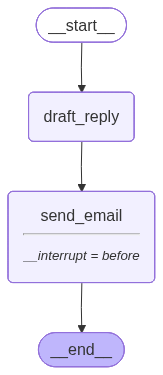

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 4. Run the Workflow (Phase 1: Drafting)
We start with a customer complaint about a broken widget.

In [5]:
thread_config = {"configurable": {"thread_id": "ticket-123"}}

initial_input = {
    "customer_query": "My widget arrived broken! I am very angry. Fix this now!"
}

# Invoking the graph. It should STOP after 'draft_reply'.
print("Starting workflow...")
for event in graph.stream(initial_input, config=thread_config):
    print(event)

print("\nWorkflow paused?", graph.get_state(thread_config).next)

Starting workflow...
--- (AI) Drafting Reply ---
{'draft_reply': {'draft_response': "Subject: Re: Damaged Widget - Apology and Assistance\n\nDear [Customer's Name],\n\nI apologize for the inconvenience and frustration caused by receiving a damaged widget. I understand how upsetting this must be, and I'm here to help resolve the issue as quickly as possible.\n\nCould you please provide me with your order number and a photo of the damaged widget? This will enable me to expedite the replacement process and ensure that you receive a new, functioning widget promptly.\n\nThank you for bringing this to my attention, and I appreciate your patience and cooperation.\n\nBest regards,\n[Your Name]\nSupport Team"}}
{'__interrupt__': ()}

Workflow paused? ('send_email',)


## 5. Human Review (Inspection)
The workflow is paused. As a manager, you need to check what the AI wrote.

In [6]:
current_state = graph.get_state(thread_config)
ai_draft = current_state.values['draft_response']

print("--- Current AI Draft ---")
print(ai_draft)

--- Current AI Draft ---
Subject: Re: Damaged Widget - Apology and Assistance

Dear [Customer's Name],

I apologize for the inconvenience and frustration caused by receiving a damaged widget. I understand how upsetting this must be, and I'm here to help resolve the issue as quickly as possible.

Could you please provide me with your order number and a photo of the damaged widget? This will enable me to expedite the replacement process and ensure that you receive a new, functioning widget promptly.

Thank you for bringing this to my attention, and I appreciate your patience and cooperation.

Best regards,
[Your Name]
Support Team


## 6. Human Correction (Update State)
Imagine the AI was too generic. We want to add a specific promise, e.g., "We will ship a replacement immediately."
We use `update_state` to overwrite the `draft_response`.

In [7]:
new_draft = ai_draft + "\n\nP.S. A replacement unit has been shipped via overnight delivery."

print("--- Updating Draft to ---")
print(new_draft)

graph.update_state(
    thread_config,
    {"draft_response": new_draft}
)

--- Updating Draft to ---
Subject: Re: Damaged Widget - Apology and Assistance

Dear [Customer's Name],

I apologize for the inconvenience and frustration caused by receiving a damaged widget. I understand how upsetting this must be, and I'm here to help resolve the issue as quickly as possible.

Could you please provide me with your order number and a photo of the damaged widget? This will enable me to expedite the replacement process and ensure that you receive a new, functioning widget promptly.

Thank you for bringing this to my attention, and I appreciate your patience and cooperation.

Best regards,
[Your Name]
Support Team

P.S. A replacement unit has been shipped via overnight delivery.


{'configurable': {'thread_id': 'ticket-123',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0f43cb-99fc-6070-8002-3d33c8f8189b'}}

## 7. Resume Execution
Now that the state is corrected, we resume. The graph will pick up at `send_email` using our *new* draft.

In [8]:
print("Resuming workflow...")
for event in graph.stream(None, config=thread_config):
    print(event)

# Check final result
final_state = graph.get_state(thread_config)
print("\nFinal Status:", final_state.values.get('final_status'))

Resuming workflow...
--- (System) Sending Email ---
{'send_email': {'final_status': "SENT: Subject: Re: Damaged Widget - Apology and Assistance\n\nDear [Customer's Name],\n\nI apologize for the inconvenience and frustration caused by receiving a damaged widget. I understand how upsetting this must be, and I'm here to help resolve the issue as quickly as possible.\n\nCould you please provide me with your order number and a photo of the damaged widget? This will enable me to expedite the replacement process and ensure that you receive a new, functioning widget promptly.\n\nThank you for bringing this to my attention, and I appreciate your patience and cooperation.\n\nBest regards,\n[Your Name]\nSupport Team\n\nP.S. A replacement unit has been shipped via overnight delivery."}}

Final Status: SENT: Subject: Re: Damaged Widget - Apology and Assistance

Dear [Customer's Name],

I apologize for the inconvenience and frustration caused by receiving a damaged widget. I understand how upsetting